### Process for ARIMA Models:

* Visualize the Time Series Data
* Make the time series data stationary
* Plot the Correlation and AutoCorrelation Charts
* Construct the ARIMA Model
* Use the model to make predictions

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('monthly-milk-production-pounds-p.csv')

## Visualize the Time Series Data

In [4]:
df.head()

,Month,Monthly milk production: pounds per cow. Jan 62 ? Dec 75
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [5]:
df.columns = ['Month','Milk in Pounds per Cow']

In [6]:
df.head()

,Month,Milk in Pounds per Cow
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [7]:
df.tail()

,Month,Milk in Pounds per Cow
164,1975-09,817.0
165,1975-10,827.0
166,1975-11,797.0
167,1975-12,843.0
168,Monthly milk production: pounds per cow. Jan 6...,NaN


In [8]:
df.drop(168,axis=0,inplace=True)

In [9]:
df.tail()

,Month,Milk in Pounds per Cow
163,1975-08,858.0
164,1975-09,817.0
165,1975-10,827.0
166,1975-11,797.0
167,1975-12,843.0


In [10]:
df['Month'] = pd.to_datetime(df['Month'])

In [11]:
df.head()

,Month,Milk in Pounds per Cow
0,1962-01-01,589.0
1,1962-02-01,561.0
2,1962-03-01,640.0
3,1962-04-01,656.0
4,1962-05-01,727.0


In [12]:
df.set_index('Month',inplace=True)

In [13]:
df.head()

,Milk in Pounds per Cow
Month,
1962-01-01,589.0
1962-02-01,561.0
1962-03-01,640.0
1962-04-01,656.0
1962-05-01,727.0


In [14]:
df.index

DatetimeIndex(['1962-01-01', '1962-02-01', '1962-03-01', '1962-04-01',
               '1962-05-01', '1962-06-01', '1962-07-01', '1962-08-01',
               '1962-09-01', '1962-10-01',
               ...
               '1975-03-01', '1975-04-01', '1975-05-01', '1975-06-01',
               '1975-07-01', '1975-08-01', '1975-09-01', '1975-10-01',
               '1975-11-01', '1975-12-01'],
              dtype='datetime64[ns]', name='Month', length=168, freq=None)

In [15]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Milk in Pounds per Cow,168.0,754.708333,102.204524,553.0,677.75,761.0,824.5,969.0


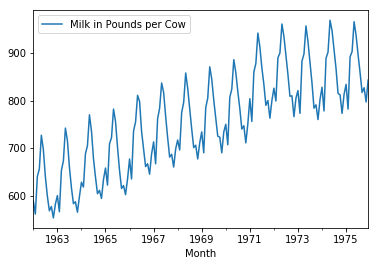

In [16]:
df.plot()

#### Looks very seasonal, with some trending.

In [17]:
time_series = df['Milk in Pounds per Cow']

In [18]:
type(time_series)

pandas.core.series.Series

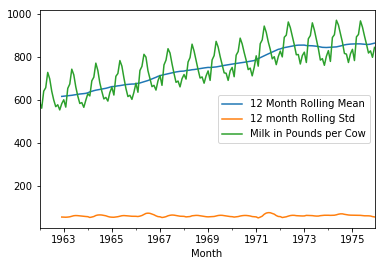

In [19]:
time_series.rolling(12).mean().plot(label='12 Month Rolling Mean')
time_series.rolling(12).std().plot(label='12 month Rolling Std')
time_series.plot()
plt.legend();

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [21]:
# Note that we chose an additive model by default.
# You also can set the freq argument
decomp = seasonal_decompose(time_series,freq=12)

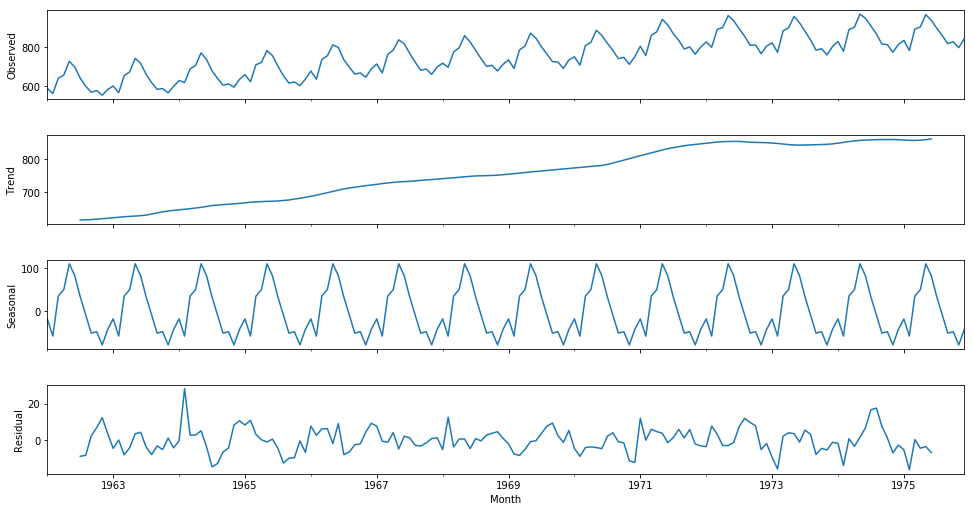

In [22]:
# Here's our ETS Decomposition
fig = decomp.plot()
fig.set_size_inches(15,8)

In [23]:
df.head()

,Milk in Pounds per Cow
Month,
1962-01-01,589.0
1962-02-01,561.0
1962-03-01,640.0
1962-04-01,656.0
1962-05-01,727.0


We want to show if this data is stationary or non-stationary using the Augmented Dickey Fuller Test. Null is non-stationary time series. 

In [24]:
from statsmodels.tsa.stattools import adfuller

In [25]:
result = adfuller(df['Milk in Pounds per Cow'])

In [26]:
# Reformat the Results
def adf_check(time_series):
    
    result = adfuller(time_series)
    print("Augmented Dickey-Fuller Test")
    labels = ['ADF Test Statistic','p-value','# of lags','Num of Observations Used']
    
    for value,label in zip(result,labels):
        print(label+ " : "+str(value))
    
    if result[1] <= 0.05:
        print("Strong evidence against the Null Hypothesis")
        print("Reject Null Hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the Null Hypothesis")
        print("Fail to reject Null Hypothesis")
        print("Data has a unit root, it is non-stationary")

In [27]:
adf_check(df['Milk in Pounds per Cow'])

Augmented Dickey-Fuller Test
ADF Test Statistic : -1.30381158742
p-value : 0.627426708603
# of lags : 13
Num of Observations Used : 154
Weak evidence against the Null Hypothesis
Fail to reject Null Hypothesis
Data has a unit root, it is non-stationary


We need to use differencing...

In [28]:
df['First Difference'] = df['Milk in Pounds per Cow'] - df['Milk in Pounds per Cow'].shift(1)

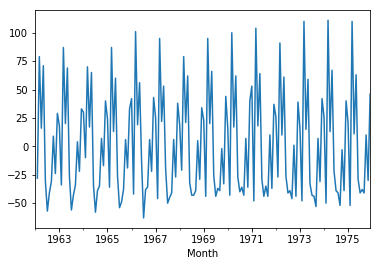

In [29]:
df['First Difference'].plot()

In [30]:
adf_check(df['First Difference'].dropna())

Augmented Dickey-Fuller Test
ADF Test Statistic : -3.05499555865
p-value : 0.0300680040018
# of lags : 14
Num of Observations Used : 152
Strong evidence against the Null Hypothesis
Reject Null Hypothesis
Data has no unit root and is stationary


Wow, we only needed to difference by one!

As an example, let's also compute the second difference.

In [31]:
df['Second Difference'] = df['First Difference'] - df['First Difference'].shift(1)

In [32]:
adf_check(df['Second Difference'].dropna())

Augmented Dickey-Fuller Test
ADF Test Statistic : -14.3278736456
p-value : 1.11269893321e-26
# of lags : 11
Num of Observations Used : 154
Strong evidence against the Null Hypothesis
Reject Null Hypothesis
Data has no unit root and is stationary


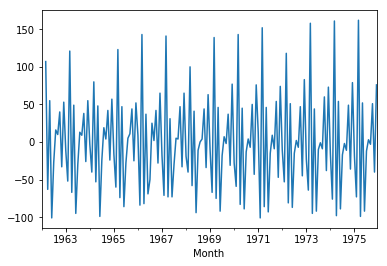

In [33]:
df['Second Difference'].plot()

We can do the same type of process to derrive a seasonal difference.

In [34]:
df['Seasonal Difference'] = df['Milk in Pounds per Cow'] - df['Milk in Pounds per Cow'].shift(12)

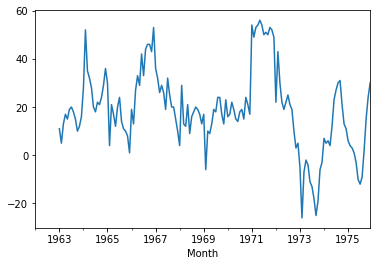

In [35]:
df['Seasonal Difference'].plot()

In [36]:
adf_check(df['Seasonal Difference'].dropna())

Augmented Dickey-Fuller Test
ADF Test Statistic : -2.33541931436
p-value : 0.160798805277
# of lags : 12
Num of Observations Used : 143
Weak evidence against the Null Hypothesis
Fail to reject Null Hypothesis
Data has a unit root, it is non-stationary


In [37]:
df['Seasonal First Difference'] = df['First Difference'] - df['First Difference'].shift(12)

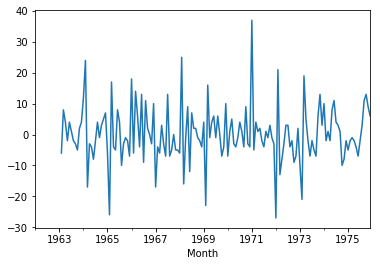

In [38]:
df['Seasonal First Difference'].plot()

In [39]:
adf_check(df['Seasonal First Difference'].dropna())

Augmented Dickey-Fuller Test
ADF Test Statistic : -5.03800227492
p-value : 1.86542343188e-05
# of lags : 11
Num of Observations Used : 143
Strong evidence against the Null Hypothesis
Reject Null Hypothesis
Data has no unit root and is stationary


In [40]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

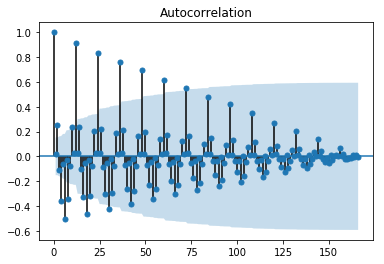

In [41]:
fig_first = plot_acf(df['First Difference'].dropna())

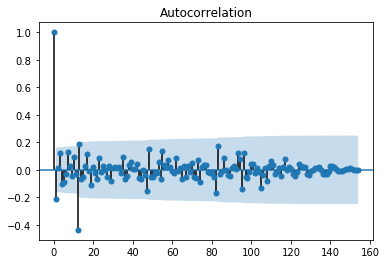

In [42]:
fig_seasonal_first = plot_acf(df['Seasonal First Difference'].dropna())

In [43]:
# You can do the same plot with Pandas
from pandas.plotting import autocorrelation_plot

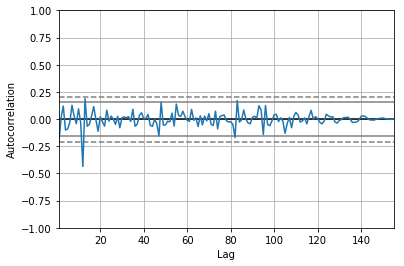

In [44]:
autocorrelation_plot(df['Seasonal First Difference'].dropna())

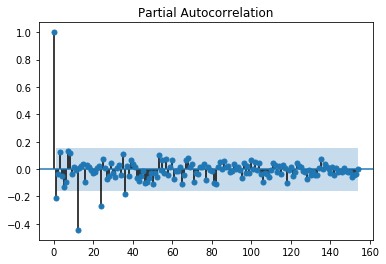

In [45]:
result = plot_pacf(df['Seasonal First Difference'].dropna())

Interpretation:

For partial autocorrelation a sharp dropp indicates you should use an autoregressive k number model.

If there is a graduala decline it is recommended to use a moving average model.

Figure(432x288)
Figure(432x288)


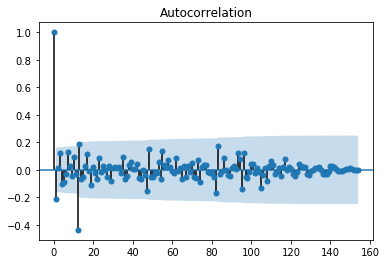

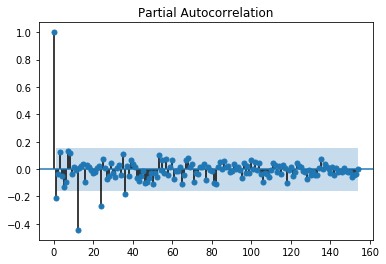

In [46]:
print(plot_acf(df['Seasonal First Difference'].dropna()))
print(plot_pacf(df['Seasonal First Difference'].dropna()))

In [47]:
from statsmodels.tsa.arima_model import ARIMA

In [48]:
help(ARIMA)

Help on class ARIMA in module statsmodels.tsa.arima_model:

class ARIMA(ARMA)
 |  Autoregressive Integrated Moving Average ARIMA(p,d,q) Model
 |  
 |  Parameters
 |  ----------
 |  endog : array-like
 |      The endogenous variable.
 |  order : iterable
 |      The (p,d,q) order of the model for the number of AR parameters,
 |      differences, and MA parameters to use.
 |  exog : array-like, optional
 |      An optional array of exogenous variables. This should *not* include a
 |      constant or trend. You can specify this in the `fit` method.
 |  dates : array-like of datetime, optional
 |      An array-like object of datetime objects. If a pandas object is given
 |      for endog or exog, it is assumed to have a DateIndex.
 |  freq : str, optional
 |      The frequency of the time-series. A Pandas offset or 'B', 'D', 'W',
 |      'M', 'A', or 'Q'. This is optional if dates are given.
 |  
 |  
 |  Notes
 |  -----
 |  If exogenous variables are given, then the model that is fit is
 

In [49]:
model = sm.tsa.statespace.SARIMAX(df['Milk in Pounds per Cow'],order=(0,1,0),seasonal_order=(1,1,1,12))

In [50]:
results = model.fit()

In [51]:
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:             Milk in Pounds per Cow   No. Observations:                  168
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -534.065
Date:                            Fri, 03 Nov 2017   AIC                           1074.131
Time:                                    18:11:33   BIC                           1083.503
Sample:                                01-01-1962   HQIC                          1077.934
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0449      0.106     -0.422      0.673      -0.253       0.163
ma.S.L12      -0.5860      0.102   

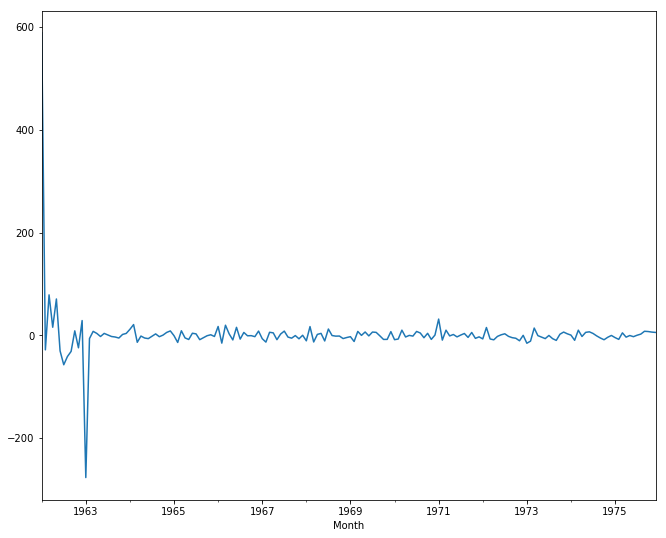

In [73]:
results.resid.plot(figsize=(11,9))

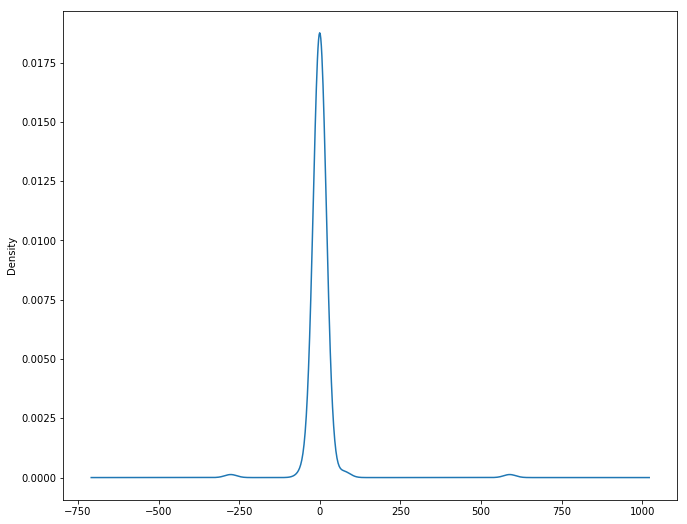

In [74]:
results.resid.plot(kind='kde',figsize=(11,9))

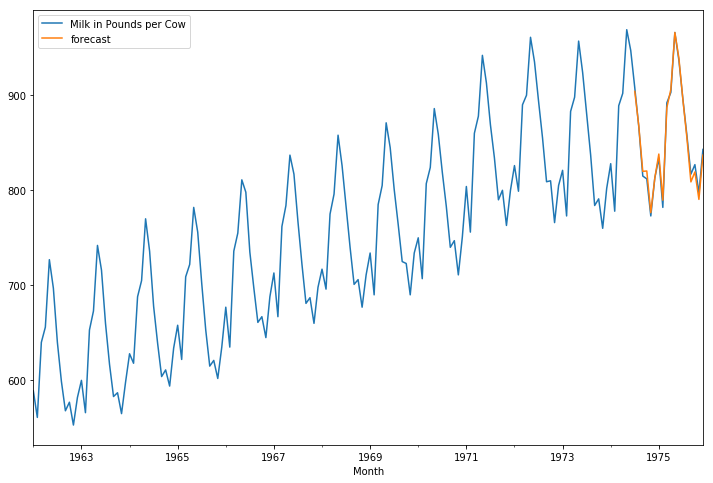

In [53]:
df['forecast'] = results.predict(start=150, end=168)
df[['Milk in Pounds per Cow','forecast']].plot(figsize=(12,8))

Look how accurate this forecast is! Adjusted for seasonality!

In [54]:
df.tail()

,Milk in Pounds per Cow,First Difference,Second Difference,Seasonal Difference,Seasonal First Difference,forecast
Month,,,,,,
1975-08-01,858.0,-38.0,3.0,-9.0,3.0,855.358617
1975-09-01,817.0,-41.0,-3.0,2.0,11.0,808.841269
1975-10-01,827.0,10.0,51.0,15.0,13.0,819.323183
1975-11-01,797.0,-30.0,-40.0,24.0,9.0,790.427500
1975-12-01,843.0,46.0,76.0,30.0,6.0,837.063646


### Add more months to our dataset to predict further out in the future

In [55]:
from pandas.tseries.offsets import DateOffset

In [56]:
future_dates = [df.index[-1] + DateOffset(months=x) for x in range(1,24)]

Create a list of future dates to append to our df.

In [57]:
future_dates

[Timestamp('1976-01-01 00:00:00'),
 Timestamp('1976-02-01 00:00:00'),
 Timestamp('1976-03-01 00:00:00'),
 Timestamp('1976-04-01 00:00:00'),
 Timestamp('1976-05-01 00:00:00'),
 Timestamp('1976-06-01 00:00:00'),
 Timestamp('1976-07-01 00:00:00'),
 Timestamp('1976-08-01 00:00:00'),
 Timestamp('1976-09-01 00:00:00'),
 Timestamp('1976-10-01 00:00:00'),
 Timestamp('1976-11-01 00:00:00'),
 Timestamp('1976-12-01 00:00:00'),
 Timestamp('1977-01-01 00:00:00'),
 Timestamp('1977-02-01 00:00:00'),
 Timestamp('1977-03-01 00:00:00'),
 Timestamp('1977-04-01 00:00:00'),
 Timestamp('1977-05-01 00:00:00'),
 Timestamp('1977-06-01 00:00:00'),
 Timestamp('1977-07-01 00:00:00'),
 Timestamp('1977-08-01 00:00:00'),
 Timestamp('1977-09-01 00:00:00'),
 Timestamp('1977-10-01 00:00:00'),
 Timestamp('1977-11-01 00:00:00')]

In [58]:
future_df = pd.DataFrame(index=future_dates,columns=df.columns)

In [59]:
final_df = pd.concat([df,future_df])

In [60]:
final_df.head()

,Milk in Pounds per Cow,First Difference,Second Difference,Seasonal Difference,Seasonal First Difference,forecast
1962-01-01,589.0,NaN,NaN,NaN,NaN,NaN
1962-02-01,561.0,-28.0,NaN,NaN,NaN,NaN
1962-03-01,640.0,79.0,107.0,NaN,NaN,NaN
1962-04-01,656.0,16.0,-63.0,NaN,NaN,NaN
1962-05-01,727.0,71.0,55.0,NaN,NaN,NaN


In [61]:
final_df.tail()

,Milk in Pounds per Cow,First Difference,Second Difference,Seasonal Difference,Seasonal First Difference,forecast
1977-07-01,NaN,NaN,NaN,NaN,NaN,NaN
1977-08-01,NaN,NaN,NaN,NaN,NaN,NaN
1977-09-01,NaN,NaN,NaN,NaN,NaN,NaN
1977-10-01,NaN,NaN,NaN,NaN,NaN,NaN
1977-11-01,NaN,NaN,NaN,NaN,NaN,NaN


Let's try and predict milk production 24 months in advance.

In [64]:
final_df['forecast'] = results.predict(start=168,end=192)

In [65]:
final_df.tail()

,Milk in Pounds per Cow,First Difference,Second Difference,Seasonal Difference,Seasonal First Difference,forecast,forcast
1977-07-01,NaN,NaN,NaN,NaN,NaN,951.525751,951.525751
1977-08-01,NaN,NaN,NaN,NaN,NaN,911.918840,911.918840
1977-09-01,NaN,NaN,NaN,NaN,NaN,865.881041,865.881041
1977-10-01,NaN,NaN,NaN,NaN,NaN,871.027162,871.027162
1977-11-01,NaN,NaN,NaN,NaN,NaN,836.962872,836.962872


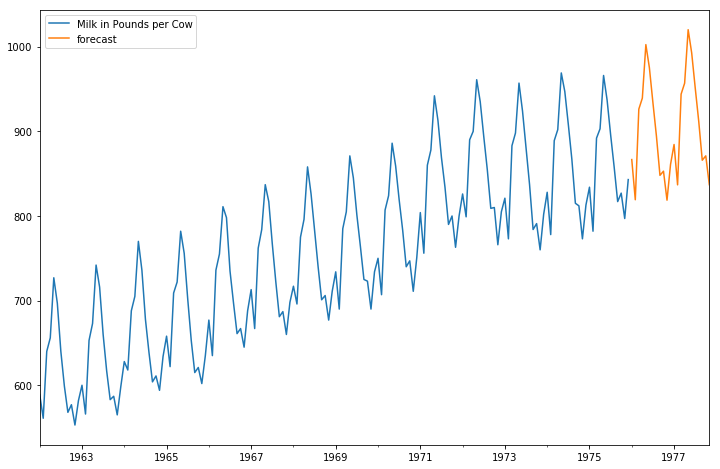

In [68]:
final_df[['Milk in Pounds per Cow','forecast']].plot(figsize=(12,8))